In [1]:
import pandas as pd
import numpy as np
import scipy.stats as si
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load and preprocess data
df = pd.read_csv("alldata_fi.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['option_name', 'Date'])


#volatility
#Compute log returns within each option_name group
df['log_return'] = df.groupby('option_name')['Spot_Price_of_Asset'].transform(lambda x: np.log(x / x.shift(1)))
# Compute rolling volatility per option_name (30-day window), annualized (using 240 trading days)
def compute_rolling_vol(group):
    group['volatility'] = group['log_return'].rolling(window=30).std() * np.sqrt(240)
    return group

df = df.groupby('option_name').apply(compute_rolling_vol).reset_index(drop=True)

# Set all option types as 'call'
df['option_type'] = 'call'

# Black-Scholes pricing function
def black_scholes_price(row):
    S = row['Spot_Price_of_Asset']
    K = row['Exercise_Price']
    T = row['time_to_expiration']
    r = row['riskfreerate']
    sigma = row['volatility']

    if T == 0 or sigma == 0 or np.isnan(sigma):
        return np.nan

    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    # Only call pricing
    return S * si.norm.cdf(d1) - K * np.exp(-r * T) * si.norm.cdf(d2)

# Apply BS model
df['BS_Option_Price'] = df.apply(black_scholes_price, axis=1)

#Keep only rows with valid calculated price
valid_df = df.dropna(subset=['BS_Option_Price', 'Closing_Price_(Option)'])

# Calculate performance metrics
y_true = valid_df['Closing_Price_(Option)']
y_pred = valid_df['BS_Option_Price']

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

# Step 8: Output
print(f"📊 Total valid entries used in BS model: {len(valid_df)}")
print(f"📈 Black-Scholes Performance Metrics:")
print(f"    - MAE  : {mae:.4f}")
print(f"    - RMSE : {rmse:.4f}")
print(f"    - R²   : {r2:.4f}")


<ipython-input-1-b09f374c0489>:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('option_name').apply(compute_rolling_vol).reset_index(drop=True)


📊 Total valid entries used in BS model: 18294
📈 Black-Scholes Performance Metrics:
    - MAE  : 254.6328
    - RMSE : 708.5775
    - R²   : 0.7210


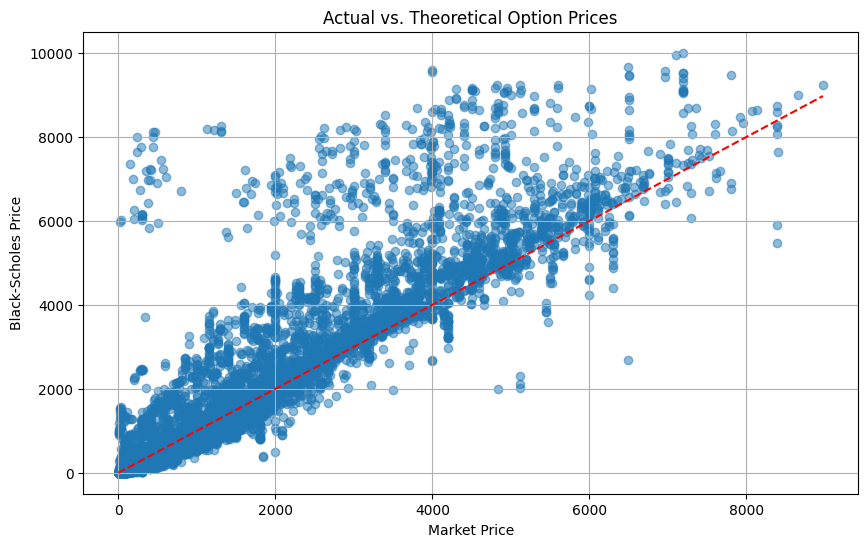

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.scatter(df['Closing_Price_(Option)'], df['BS_Option_Price'], alpha=0.5)
plt.plot([0, df['Closing_Price_(Option)'].max()], [0, df['Closing_Price_(Option)'].max()], color='red', linestyle='--')
plt.xlabel('Market Price')
plt.ylabel('Black-Scholes Price')
plt.title('Actual vs. Theoretical Option Prices')
plt.grid(True)
plt.show()
